# INIT

In [1]:
# INITIALIZATION CELL
import ipywidgets as widgets
import pandas as pd
from plot_helpers3 import *

############### Experiment selection ###################

# Obtain the list of experiments
EXP_list = [exp_folder.split('/')[-1] for exp_folder in sorted(glob.glob('%s/*' % datadir))]

# Obtain the mapping experiment -> configs
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir, exp)))] for exp in EXP_list}

# Obtain the mapping experiment/config -> reps
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir, exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

# Define all the widgets to be used
EXP_drop    = widgets.Dropdown(description='Exp:', options=EXP_list, value=EXP_list[-1], disabled=False)
EXP_mult    = widgets.SelectMultiple(description='Exp:', options=EXP_list, value=[EXP_list[-1]], disabled=False, layout=widgets.Layout(height=f'{len(EXP_list) * 18}px'))
CFG_drop    = widgets.Dropdown(description='Cfg:', options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:', options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict['longrun/'+CFG_drop.value]
            
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict['longrun/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_mult_df(lf, select = True, select_only = False, experiments = []):
    global df_exp, logfile, loaded

    logfile = lf
    
    # Select which experiment to plot
    if select:
        grid = widgets.GridspecLayout(1,2)
        grid[0,0] = EXP_mult
        grid[0,1] = CONF_button
        display(grid)
    
    if select_only:
        return None
        
    if not experiments:
        experiments = EXP_mult.value

    df = pd.DataFrame()
    for EXP in experiments:
        df_exp = create_df(EXP, logfile)      
        df = pd.concat([df, df_exp], ignore_index=True)
            
    loaded = (experiments, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
    return df

load_mult_df('', select_only = True)

GridspecLayout(children=(SelectMultiple(description='Exp:', index=(2,), layout=Layout(grid_area='widget001', h…

In [11]:
# ===== Thesis plotting style (matplotlib + seaborn) =====
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cycler import cycler
from scipy.stats import linregress

PALETTE = [
    "#99C1E9",  # blue
    "#99CCBB",  # orange
    "#ED9696",  # teal
    "#ED9696",  # red
    "#33BBEE",  # sky blue
    "#EE3377",  # magenta
    "#BBBBBB",  # grey
    "#228833",  # green
]

# Optional: a darker variant for lines/edges
EDGE_COLOR = "#222222"

def set_thesis_style(font_family="sans-serif", font_sans=("Arial", "DejaVu Sans"),
                     base_font=10, lines_lw=2.4, grid_alpha=0.25, y_minor_grid=True):
    """
    Apply a clean, publication-ready style with thicker strokes and
    subtle grids focused on the y-axis (great for box/violin/bar).
    """
    # Seaborn theme first (sets context + default rc)
    sns.set_theme(style="whitegrid", context="paper")
    sns.set_context("paper", font_scale=1)  # keep metrics predictable
    sns.set_palette(PALETTE)

    # Matplotlib rcParams (overrides)
    mpl.rcParams.update({
        # --- Fonts ---
        "font.size": base_font,
        "font.family": font_family,
        "font.sans-serif": list(font_sans),
        "axes.titlesize": base_font + 2,
        "axes.labelsize": base_font + 1,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",

        # --- Figure ---
        "figure.dpi": 160,          # nice in-notebook DPI
        "savefig.dpi": 600,         # sharp exports
        "savefig.bbox": "tight",
        "figure.facecolor": "white",
        "axes.facecolor": "white",

        # --- Axes & spines ---
        "axes.edgecolor": EDGE_COLOR,
        "axes.linewidth": 1.1,
        "axes.grid": True,
        "axes.grid.axis": "y",
        "grid.linestyle": "-",
        "grid.linewidth": 0.8,
        "grid.alpha": grid_alpha,

        # --- Ticks ---
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "xtick.minor.size": 2.5,
        "ytick.minor.size": 2.5,
        "xtick.minor.width": 1.0,
        "ytick.minor.width": 1.0,

        # --- Lines & patches ---
        "lines.linewidth": lines_lw,
        "patch.linewidth": 1.2,
        "hatch.linewidth": 0.8,

        # --- Legend ---
        "legend.frameon": False,
        "legend.title_fontsize": base_font,
        "legend.fontsize": base_font - 1,
        "legend.handlelength": 1.8,

        # --- Errorbar defaults (great for pointplots/barplots) ---
        "errorbar.capsize": 3,

        # --- Boxplot defaults (seaborn uses mpl artists under the hood) ---
        "boxplot.flierprops.marker": "o",
        "boxplot.flierprops.markersize": 3.0,
        "boxplot.flierprops.markeredgewidth": 0.6,
        "boxplot.boxprops.linewidth": 1.25,
        "boxplot.whiskerprops.linewidth": 1.25,
        "boxplot.capprops.linewidth": 1.25,
        "boxplot.medianprops.linewidth": 2.2,  # emphasize median
        "boxplot.meanprops.linewidth": 2.2,

        # --- Tight, consistent whitespace ---
        "axes.titlepad": 8,
        "axes.labelpad": 6,
    })

    # Cycler for colors + marker cycle (helps lines stand out)
    markers = ["o", "s", "D", "^", "v", "P", "X", None]

    mpl.rcParams["axes.prop_cycle"] = cycler(color=PALETTE)

    # Minor grid on y only (nice for reading distributions)
    ax = plt.gca() if plt.get_fignums() else None
    if y_minor_grid and ax is not None:
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.grid(True, which="minor", axis="y", alpha=grid_alpha*0.7, linewidth=0.6)

def thesis_style(**kwargs):
    """
    Context manager to temporarily apply the thesis style.
    Usage:
        with thesis_style():
            fig, ax = plt.subplots()
            ...
    """
    class _ThesisContext:
        def __enter__(self_inner):
            self_inner._old = mpl.rcParams.copy()
            set_thesis_style(**kwargs)
        def __exit__(self_inner, exc_type, exc, tb):
            mpl.rcParams.update(self_inner._old)
    return _ThesisContext()

palette=PALETTE

def boxstrip_with_top_stats(
    df,
    ax,
    y,
    hue=None,
    x="num_byz",
    box_color="#4C78A8",
    strip_color="black",
    strip_size=2.5,
    strip_alpha=1.0,
    jitter=0.2,
    median_color="k",
    cap_color="k",
    line_width=1.5,
    order=None,
    palette=None,
    show_legend=False,
    box_widths=None
):

    if palette:
        box_color=None
    # 1) Box bodies (behind everything else)
    sns.boxplot(
        data=df, x=x, y=y, ax=ax, order=order,
        color=box_color, hue=hue, dodge=True, palette=palette,
        showcaps=False,                     # draw caps later
        boxprops=dict(edgecolor='white', linewidth=0),
        whiskerprops=dict(linestyle='-', linewidth=line_width),
        flierprops=dict(marker=""),         # hide outliers
        medianprops=dict(color='none'),     # hide median for now
        zorder=1
    )

    # 2) Points (between box bodies and top stats)
    sns.stripplot(
        data=df, x=x, y=y, ax=ax, order=order, hue=hue, dodge=True,
        color=strip_color, alpha=strip_alpha, size=strip_size, jitter=jitter,
        zorder=2
    )

    # 3) Medians + Caps only (on top)
    sns.boxplot(
        data=df, x=x, y=y, ax=ax, order=order,
        showcaps=True, hue=hue, dodge=True, palette=palette,
        boxprops=dict(facecolor='none', edgecolor='none'),
        whiskerprops=dict(color='none'),
        flierprops=dict(marker=""),
        medianprops=dict(color=median_color, linewidth=line_width),
        capprops=dict(color=cap_color, linewidth=line_width),
        zorder=3
    )
    if not show_legend and ax.legend_:
        ax.legend_.remove()
    ax.set_zorder(0)  # (optional) keep axes behind artists
    return ax


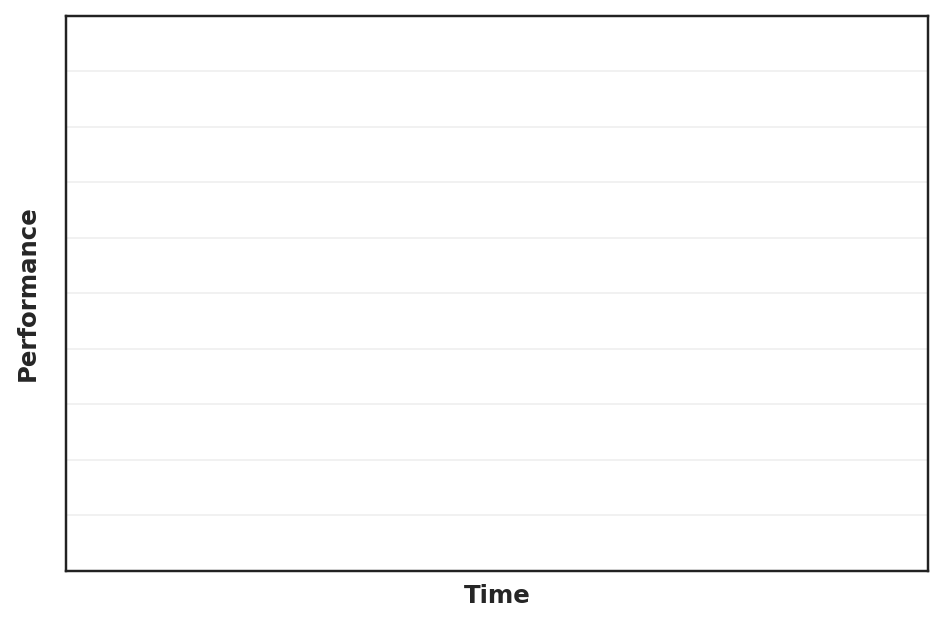

In [12]:
set_thesis_style()

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

# Limits (tune as needed)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1)

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Performance")

# No ticks
ax.set_xticks([])
ax.set_yticks([])

# Horizontal gridlines only
ax.yaxis.grid(True, which='major')
ax.xaxis.grid(False)

# Light minor gridlines (optional)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.grid(True, which='minor', alpha=0.3)

plt.tight_layout()
plt.savefig("frame_only.svg", format="svg")
plt.show()


# Research per year

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

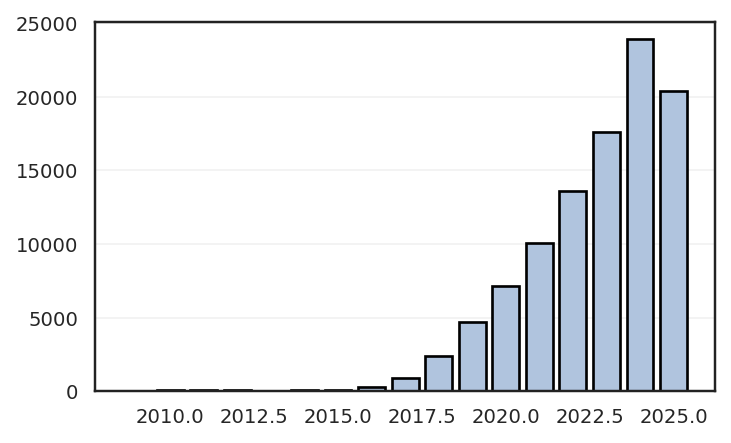

In [13]:
set_thesis_style()
from matplotlib.ticker import MaxNLocator
data = {
    "Year": [
        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025
    ],
    "Count": [
        50, 57, 62, 61, 41, 74, 116, 269,
        881, 2430, 4710, 7170, 10100, 13600,
        17600, 23900, 20400
    ]
}

df = pd.DataFrame(data)

# Label the last entry as YTD for plotting
labels = df["Year"].astype(str).tolist()
labels[-1] = "2025\n(YTD)"

# Exclude 2025 from trend line
df_trend = df[df["Year"] < 2025]

# --- Plot ---
fig = plt.figure(figsize=(5, 3))

# Bars
plt.bar(df["Year"], df["Count"], color="lightsteelblue", edgecolor="black", label="Publications")

# Trend line (excluding 2025)
plt.plot(df_trend["Year"], df_trend["Count"], color="darkblue", linewidth=2.5, marker="o", label="Trend")

# --- Styling ---
# plt.title("Publications Combining Blockchain and Robotics (2009–2025 YTD)", fontsize=13)
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.grid(alpha=0.3)
plt.legend()

# Integer ticks & custom labels
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(df["Year"], labels, rotation=45)

# Optional: log scale
# plt.yscale("log")
# plt.yticks([100, 1000, 10000], ["100", "1 000", "10 000"])

plt.tight_layout()
plt.show()

fig.savefig("plots/new/publications.pdf", bbox_inches='tight', dpi=600)

# Bitcoin Hashrate

In [ ]:
import json
JSON_PATH = "/home/eksander/geth-pi-pucks/results/data/bitcoin-hashrate.json"

set_thesis_style()

# Load JSON
with open(JSON_PATH, "r") as f:
    data = json.load(f)

# Extract the hash-rate data
hash_data = data["hash-rate"]

# Convert to DataFrame
df = pd.DataFrame(hash_data)

# Convert timestamp from milliseconds to datetime
df["date"] = pd.to_datetime(df["x"], unit="ms")

# Rename columns for clarity
df = df.rename(columns={"y": "hashrate"})
df["hashrate_Hs"] = df["hashrate"] * 1e12

# Plot
fig = plt.figure(figsize=(5, 3), facecolor="none")
plt.axhline(1e21, color="gray", linestyle=":", label="1 ZH/s")
sns.lineplot(x="date", y="hashrate_Hs", data=df, color="darkblue", label="Bitcoin hashrate")

plt.yscale("log")
plt.xlabel("")
plt.xlim(pd.Timestamp("2009-02-01"), pd.Timestamp("2026-01-01"))
plt.ylabel("Hashrate (H/s)")
plt.legend()
plt.grid(True)
plt.show()

fig.savefig("plots/new/hashrate.pdf", bbox_inches='tight', dpi=600)

# Robustness

In [ ]:
# --- Load & preprocess ---
df_sc = load_mult_df('sc', False, experiments=['experiment_1', 'Experiment_G1', 'Experiment_G1_sim'])

In [ ]:
set_thesis_style()
df = df_sc
df = (
    df[df["C?"] == True]
      .groupby(["EXP", "CFG", "REP", "ID"], as_index=False)
      .first()
      .sort_values(["EXP", "CFG", "REP", "TIME"])
      .drop_duplicates(subset=["EXP", "CFG", "REP"], keep="last")
      .reset_index(drop=True)
)

df["TIME"] = df["TIME"] / 60  # minutes
df["num_byz"] = df["CFG"].str.extract(r"(\d+)byz").astype(int)

# Consensus error target per experiment
target_map = {"experiment_1": 32, "Experiment_G1": 25, "Experiment_G1_sim": 25}
df["E"] = (df["MEAN"] / 1e5 - df["EXP"].map(target_map)).abs()

df["#VOTES"] = df["#VOTES"]/df["#ROBOT"]

# --- Figure & palettes ---
fs = (6, 6)
fig, axes = plt.subplots(3, 2, figsize=fs, sharex='col', width_ratios=[4, 6])

left_exp = "experiment_1"
right_exps = ["Experiment_G1", "Experiment_G1_sim"]

palette_map = {
    left_exp: palette[0],            
    right_exps[0]: palette[1],       
    right_exps[1]: palette[2],       
}

rows = [
    ("E",        "Consensus\nerror (%)"),
    ("TIME",     "Convergence\ntime (min)"),
    ("#VOTES",   "Reports\nper robot"),
]

# --- Plot one row at a time ---
for r, (y, ylab) in enumerate(rows):
    
    # Left column: experiment_1 only
    ax = axes[r, 0]
    boxstrip_with_top_stats(
        df.query("EXP == @left_exp"),
        ax, y, x="num_byz", hue='EXP',
        palette=palette_map
    )
    ax.set_ylabel(ylab)

    # Right column: G5 vs G5_sim with shared x-axis, distinguished by hue
    ax = axes[r, 1]
    boxstrip_with_top_stats(
        df[df["EXP"].isin(right_exps)],
        ax, y, x="num_byz", hue='EXP',
        palette=palette_map
    )
    ax.set_ylabel("")


axes[0, 0].set_ylim([0,29.95])
axes[0, 1].set_ylim([0,4.85])

axes[1, 0].set_ylim([0,15.5]); axes[1, 0].set_yticks([0,3,6,9,12])
axes[1, 1].set_ylim([0,99])

axes[2, 0].set_ylim([0,14.9]); axes[2, 0].set_yticks([0,3,6,9,12])
axes[2, 1].set_ylim([0,14.9]); axes[2, 1].set_yticks([0,3,6,9,12])

axes[2, 0].set_xlabel("Number of Byzantine\nrobots (out of 10)")
axes[2, 1].set_xlabel("Number of Byzantine\nrobots (out of 24)")

for ax in axes.flat:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

plt.tight_layout()
plt.show()

# Save
fig.savefig("chapter_6_poc/robustness.pdf", bbox_inches='tight', dpi=600)


# Scalability - consensus (constant arena)

In [ ]:
# --- Load & preprocess ---
df_sc = load_mult_df('sc', False, experiments=['experiment_2', 'Experiment_G5', 'Experiment_G5_sim'])

Dataset /home/dodo/toychain-argos/BachelorProjekt/results/data/experiment_2 not found
Dataset /home/dodo/toychain-argos/BachelorProjekt/results/data/Experiment_G5 not found
Dataset /home/dodo/toychain-argos/BachelorProjekt/results/data/Experiment_G5_sim not found
Loaded || dataframe: ['experiment_2', 'Experiment_G5', 'Experiment_G5_sim'] datafile: sc


In [ ]:
set_thesis_style()
df = df_sc
df = (
    df.sort_values(["EXP", "CFG", "REP", "TIME"])
      .drop_duplicates(subset=["EXP", "CFG", "REP"], keep="last")
      .reset_index(drop=True)
)

df["TIME"] = df["TIME"]/60
df["#VOTES"] = df["#VOTES"]/df["#ROBOT"]

target_map = {"experiment_2": 32, "Experiment_G5": 25, "Experiment_G5_sim": 25}
df["E"] = (df["MEAN"] / 1e5 - df["EXP"].map(target_map)).abs()

# Create figure
fs = (6, 6)
fig, axes = plt.subplots(3, 2, figsize=fs, sharex='col', width_ratios=[4, 6])

left_exp = "experiment_2"
right_exps = ["Experiment_G5", "Experiment_G5_sim"]

palette_map = {
    "experiment_2": palette[0],     # blue
    "Experiment_G5": palette[1],    # orange
    "Experiment_G5_sim": palette[2] # teal
}

rows = [
    ("E",    "Consensus\nerror (%)"),
    ("TIME", "Convergence\ntime (min)"),
    ("#VOTES", "Reports\nper robot"),
]

# --- Plot row by row ---
for r, (y, ylab) in enumerate(rows):
    
    # Left column: experiment_2 only
    ax = axes[r, 0]
    boxstrip_with_top_stats(
        df.query(f'EXP == "{left_exp}"'),
        ax, y, x="#ROBOT", hue='EXP',
        palette=palette_map
    )
    ax.set_ylabel(ylab)

    # Right column: G5 vs G5_sim with shared x-axis, distinguished by hue
    ax = axes[r, 1]
    boxstrip_with_top_stats(
        df[df["EXP"].isin(right_exps)],
        ax, y, x="#ROBOT", hue='EXP',
        palette=palette_map
    )
    ax.set_ylabel("")


# X labels only on bottom row
axes[2, 0].set_xlabel("Number of robots")
axes[2, 1].set_xlabel("Number of robots")

# --- Y-limits for consistency ---
axes[0, 0].set_ylim([0, 8])
axes[0, 1].set_ylim([0, 4])

axes[1, 0].set_ylim([0, 12])
axes[1, 1].set_ylim([0, 40])

axes[2, 0].set_ylim([0, 10])
axes[2, 1].set_ylim([0, 10])

plt.tight_layout()
plt.show()

# Save
fig.savefig("plots/new/scalability_consensus_constant_arena.pdf", bbox_inches='tight', dpi=600)

KeyError: 'EXP'

# Scalability - consensus (constant density)

In [ ]:
set_thesis_style()
# Load your data
# df_load = load_mult_df('sc', False, experiments=['Experiment_G9', 'Experiment_G9_sim'])

# Process data
df = df_load
df = (
    df[df["C?"] == True]
    .groupby(["EXP", "CFG", "REP", "ID"], as_index=False)
    .first()
)

df = (
    df.sort_values(["EXP", "CFG", "REP", "TIME"])
      .drop_duplicates(subset=["EXP", "CFG", "REP"], keep="last")
      .reset_index(drop=True)
)

df["TIME"] = df["TIME"]/60
df["num_rob"] = df["CFG"].str.extract(r"(\d+)rob").astype(int)

df["#VOTES"] = df["#VOTES"].fillna(df["VOTECOUNT"])
df["#VOTES"] = df["#VOTES"]/df["num_rob"]

df["E"] = np.abs(25 - df["MEAN"] / 1e5)

# Create figure
fs = np.array((6, 6))
fig, axes = plt.subplots(3, 1, figsize=fs, sharex='col', sharey='row')

palette_map = {
    "Experiment_G9": palette[1],    
    "Experiment_G9_sim": palette[2] 
}

rows = [
    ("E",    "Consensus\nerror (%)"),
    ("TIME", "Convergence\ntime (min)"),
    ("#VOTES", "Reports\nper robot"),
]

# --- Plot row by row ---
for r, (y, ylab) in enumerate(rows):
    ax = axes[r]
    boxstrip_with_top_stats(df, ax, y, x="num_rob", hue='EXP', palette=palette_map)
    ax.set_ylabel(ylab)

# === customization ===
for ax in axes.flat:
    ax.set_xlabel("Number of robots")

# === save ===
plt.tight_layout()
plt.show()
fig.savefig("plots/new/scalability_consensus_constant_density.pdf", bbox_inches='tight', dpi=600)
display(df)

NameError: name 'df_load' is not defined

# Scalability - synchronization (constant arena)

In [ ]:
# df_block1 = load_mult_df('block', False, experiments=['experiment_2', 'Experiment_G5', 'Experiment_G5_sim'])
# df_sync1  = load_mult_df('sync', False, experiments=['experiment_2', 'Experiment_G5', 'Experiment_G5_sim'])
# df_buff1  = load_mult_df('buffer', False, experiments=['experiment_2', 'Experiment_G5', 'Experiment_G5_sim'])

df_block1 = load_mult_df('block', False, experiments=['experiment_2', 'Experiment_G5'])
df_sync1  = load_mult_df('sync', False, experiments=['experiment_2', 'Experiment_G5'])
df_buff1  = load_mult_df('buffer', False, experiments=['experiment_2', 'Experiment_G5'])

In [ ]:
# === load data ===
df_block = df_block1 
df_sync  = df_sync1
df_buff  = df_buff1

# === process data ===
df_block = df_block.groupby(EXP_CFG_REP, as_index=False).agg({
    "BLOCK": "max",
    "HASH": "nunique",
    "TELAPSED":"mean",
    "TIME":"max"
})
df_block['block_efficiency'] = df_block['BLOCK'] / df_block['HASH'] * 100
df_block["num_rob"] = df_block["CFG"].str.extract(r"(\d+)rob").astype(int)

df_block['abp'] = df_block['TIME']/df_block['BLOCK']
display(df_block1)

In [ ]:
set_thesis_style()

# === load data ===
df_block = df_block1 
df_sync  = df_sync1
df_buff  = df_buff1

# keep a source copy to avoid shadowing during overwrite
df0 = df_block

# 1) index of row where BLOCK is max per group
imax = df0.groupby(EXP_CFG_REP)['BLOCK'].idxmax()

# 2) TIME at that row
time_at_max = df0.loc[imax, EXP_CFG_REP + ['TIME']]

# 3) your other aggregations
agg = df0.groupby(EXP_CFG_REP, as_index=False).agg(
    BLOCK_min=('BLOCK', 'min'),
    BLOCK=('BLOCK', 'max'),
    HASH=('HASH', 'nunique'),
    TELAPSED=('TELAPSED', 'mean'),
)

# mainchains = get_mainchains(df_block)

# # Generate the dataframe
# df1 = df_block[df_block['HASH'].isin(mainchains)]
# df1 = df1.drop_duplicates('HASH').sort_values(EXP_CFG_REP+['BLOCK']).reset_index()
# df1['ABP'] = df1.groupby(EXP_CFG_REP)['TIMESTAMP'].diff()
# df1 = df1.dropna(subset=['ABP'])
# df1["num_rob"] = df1["CFG"].str.extract(r"(\d+)rob").astype(int)
# display(df1)

# 4) bring TIME in
df_block = agg.merge(time_at_max, on=EXP_CFG_REP, how='left')

df_block['BPU'] = (df_block['BLOCK']-df_block['BLOCK_min']) / df_block['HASH'] * 100
df_block['RBP'] = df_block['TIME']/(df_block['BLOCK']-df_block['BLOCK_min'])
df_block['BPT'] = df_block['TELAPSED']
df_block["num_rob"] = df_block["CFG"].str.extract(r"(\d+)rob").astype(int)


df_sync = df_sync.groupby(EXP_CFG_REP_ID, as_index=False).agg({'#BLOCKS':'sum', 'TIME':'max'})
df_sync["BPM"] = df_sync["#BLOCKS"]/df_sync["TIME"]*60



df_buff["time_diff"] = df_buff.groupby(EXP_CFG_REP_ID)['TIME'].diff()
df_buff["peer_minutes"] = df_buff['#GETH'] * df_buff["time_diff"]
df_buff = df_buff.groupby(EXP_CFG_REP_ID, as_index=False).agg({
    "TIME": "max",
    "peer_minutes": 'sum',
    '#GETH': lambda x: x[x > 0].mean() if (x > 0).any() else 0
})

df_buff["AVG_PEERS"] = df_buff['peer_minutes'] / df_buff['TIME']

df_buff = df_buff.groupby(EXP_CFG_REP, as_index=False).agg({'AVG_PEERS':'mean'})
df_sync = df_sync.groupby(EXP_CFG_REP, as_index=False).agg({'BPM':'mean'})

df_buff["num_rob"] = df_buff["CFG"].str.extract(r"(\d+)rob").astype(int)
df_sync["num_rob"] = df_sync["CFG"].str.extract(r"(\d+)rob").astype(int)

palette_map = {
    "experiment_2": palette[0],     # blue
    "Experiment_G5": palette[1],    # orange
    "Experiment_G5_sim": palette[2] # teal
}

# experiments = ["experiment_2", "Experiment_G5", "Experiment_G5_sim"]

# === figure ===
fs = np.array((4, 6))
fig, axes = plt.subplots(5, 2, figsize=fs, sharex='col', sharey='row', width_ratios=[6, 4])

# define grouping: single, combined
exp_groups = [
    ["experiment_2"],
    ["Experiment_G5", "Experiment_G5_sim"]
]

# ============================================================
# ROW 0: Connected-time fraction
for col, group in enumerate(exp_groups):
    ax = axes[0, col]
    boxstrip_with_top_stats(df_buff.query(f'EXP in {group}'), ax, 'AVG_PEERS', x="num_rob", hue='EXP', palette=palette_map)
    # sns.boxplot(
    #     data=df_buff.query(f'EXP in {group}'),
    #     x="num_rob", y="AVG_PEERS",
    #     hue="EXP", ax=ax, palette=palette_map
    # )

# ============================================================
# ROW 1: Blocks per synchronization
for col, group in enumerate(exp_groups):
    ax = axes[1, col]
    boxstrip_with_top_stats(df_sync.query(f'EXP in {group}'), ax, 'BPM', x="num_rob", hue='EXP', palette=palette_map)
    # sns.boxplot(
    #     data=df_sync.query(f'EXP in {group}'),
    #     x="num_rob", y="BPM",
    #     hue="EXP", ax=ax, palette=palette_map
    # )

# ============================================================
# ROW 2: Block propagation time
for col, group in enumerate(exp_groups):
    ax = axes[2, col]
    boxstrip_with_top_stats(df_block.query(f'EXP in {group}'), ax, 'BPT', x="num_rob", hue='EXP', palette=palette_map)
    # sns.boxplot(
    #     data=df_block.query(f'EXP in {group}'),
    #     x="num_rob", y="BPT",
    #     hue="EXP", ax=ax, palette=palette_map
    # )

# ============================================================
# ROW 3: Real block period
for col, group in enumerate(exp_groups):
    ax = axes[3, col]
    boxstrip_with_top_stats(df_block.query(f'EXP in {group}'), ax, 'RBP', x="num_rob", hue='EXP', palette=palette_map)
    # sns.violinplot(
    #     data=df1.query(f'EXP in {group}'),
    #     x="num_rob", y="ABP",
    #     hue="EXP", ax=ax, palette=palette_map
    # )
    # sns.stripplot(
    #     data=df_block.query(f'EXP in {group}'),
    #     x="num_rob", y="RBP",
    #     hue="EXP", ax=ax, palette=palette_map, alpha=0.3
    # )

# ============================================================
# ROW 4: Block production efficiency
for col, group in enumerate(exp_groups):
    ax = axes[4, col]
    boxstrip_with_top_stats(df_block.query(f'EXP in {group}'), ax, 'BPU', x="num_rob", hue='EXP', palette=palette_map)
    # sns.boxplot(
    #     data=df_block.query(f'EXP in {group}'),
    #     x="num_rob", y="BPU",
    #     hue="EXP", ax=ax, palette=palette_map
    # )

# === labels and limits ===
for col in range(2):
    axes[4, col].set_xlabel("Number of robots")

axes[0,0].set_ylabel("APC")
axes[1,0].set_ylabel("BPM")
axes[2,0].set_ylabel("BPD (s)")
axes[3,0].set_ylabel("ABP (s)")
axes[4,0].set_ylabel("BPE (%)")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[2,1].set_ylabel("")
axes[3,1].set_ylabel("")
axes[4,1].set_ylabel("")

# axes[0,0].set_yticks([0, 0.5, 1, 1.5])
# axes[0,0].set_ylim([0, 1.6])
# axes[1,0].set_yticks([0,2,4,6,8, 10])

# axes[1,0].set_yticks([0,2,4,6,8, 10])
# axes[1,1].set_yticks([0,1,2,3,4, 5])

# axes[2,0].set_ylim([10, 40])
# axes[2,1].set_ylim([10, 100])

# axes[3,0].set_ylim([15, 24])
# axes[3,1].set_ylim([15, 70])
# axes[3,0].set_yticks([15,18, 21,24])
# axes[3,1].set_yticks([15,25,35,45,55,65])


# axes[4,0].set_ylim([0, 100])
# axes[4,1].set_ylim([0, 100])

# === remove duplicate legends ===
for ax_row in axes:
    for ax in ax_row:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

plt.tight_layout()  # make room for legend on the right
plt.show()
fig.savefig("plots/new/scalability_sync.pdf", bbox_inches='tight', dpi=600)


# Scalability - synchronization (constant swarm density)

In [ ]:
set_thesis_style()


# load data
# df_block1 = load_mult_df('block', False, experiments=['Experiment_G9', 'Experiment_G9_sim'])
df_block = df_block1

# Process data 
df_block["HASH"] = df_block["BLOCK"].astype(str) + "_" + df_block["TXS"].astype(str)
df_block = df_block.groupby(EXP_CFG_REP, as_index=False).agg({"BLOCK": "max", "HASH": "nunique", "TELAPSED":"mean"})

# keep a source copy to avoid shadowing during overwrite
df0 = df_block1

# 1) index of row where BLOCK is max per group
imax = df0.groupby(EXP_CFG_REP)['BLOCK'].idxmax()

# 2) TIME at that row
time_at_max = df0.loc[imax, EXP_CFG_REP + ['TIME']]

# 3) your other aggregations
agg = df0.groupby(EXP_CFG_REP, as_index=False).agg(
    BLOCK_min=('BLOCK', 'min'),
    BLOCK=('BLOCK', 'max'),
    HASH=('HASH', 'nunique'),
    TELAPSED=('TELAPSED', 'mean'),
)


# 4) bring TIME in
df_block = agg.merge(time_at_max, on=EXP_CFG_REP, how='left')

df_block['BPE'] = (df_block['BLOCK']-df_block['BLOCK_min']) / df_block['HASH'] * 100
df_block['ABP'] = df_block['TIME']/(df_block['BLOCK']-df_block['BLOCK_min'])
df_block['BPT'] = df_block['TELAPSED']
df_block["num_rob"] = df_block["CFG"].str.extract(r"(\d+)rob").astype(int)


palette_map = {
    "Experiment_G9": palette[1],    # orange
    "Experiment_G9_sim": palette[2] # teal
}


# Create figure
fs = np.array((6, 6))
fig, axes = plt.subplots(3, 1, figsize=fs, sharex='col', sharey='row')


#####################################################################################
## FIRST COLUMN: EXPERIMENT_G9 (REAL)
exp_name = 'Experiment_G9'

# Row 0: Block production efficiency
XX = 'num_rob'
YY = 'BPT'
ax = axes[0]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])
# boxstrip_with_top_stats(df_block.query('num_rob<25'), ax, YY, x=XX, hue='EXP', palette=palette_map)
# boxstrip_with_top_stats(df_block.query('num_rob>25'), axes[0], YY, x=XX, hue='EXP', palette=palette_map)
boxstrip_with_top_stats(df_block, axes[0], YY, x=XX, hue='EXP', palette=palette_map)

# Row 1: Average block period time
XX = 'num_rob'
YY = 'ABP'
ax = axes[1]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])
# boxstrip_with_top_stats(df_block.query('num_rob<25'), ax, YY, x=XX, hue='EXP', palette=palette_map)
# boxstrip_with_top_stats(df_block.query('num_rob>25'), ax, YY, x=XX, hue='EXP', palette=palette_map)
boxstrip_with_top_stats(df_block, ax, YY, x=XX, hue='EXP', palette=palette_map)


# Row 2: Block travel time
XX = 'num_rob'
YY = 'BPE'
ax = axes[2]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])
# boxstrip_with_top_stats(df_block.query('num_rob<25'), ax, YY, x=XX, hue='EXP', palette=palette_map)
# boxstrip_with_top_stats(df_block.query('num_rob>25'), ax, YY, x=XX, hue='EXP', palette=palette_map)
boxstrip_with_top_stats(df_block, ax, YY, x=XX, hue='EXP', palette=palette_map)


# === customization ===
axes[2].set_xlabel("Number of robots")

axes[0].set_ylabel("BPT (s)\n")
axes[1].set_ylabel("ABP (s)\n")
axes[2].set_ylabel("BPE (%)\n")

axes[0].text(-0.07, 2.9, "(block propagation time)", fontsize= 8,
        transform=ax.transAxes,
        rotation=90, va='center', ha='right')

axes[1].text(-0.07, 1.7, "(average block period)", fontsize= 8,
        transform=ax.transAxes,
        rotation=90, va='center', ha='right')

axes[0].text(-0.07, 0.5, "(block production efficiency)", fontsize= 8,
        transform=ax.transAxes,
        rotation=90, va='center', ha='right')


# === save ===
plt.tight_layout()
plt.show()
fig.savefig("plots/new/scalability_blockchain_constant_density.pdf", bbox_inches='tight', dpi=600)

# Hardware CPU

In [ ]:
set_thesis_style()

# load data
df_extra = load_mult_df('extra', False, experiments=['experiment_2', 'Experiment_G6', 'Experiment_G9'])


df_extra = df_extra.groupby(EXP_CFG_REP, as_index=False).agg({'%CPU':'mean'})
df_extra["num_rob"] = df_extra["CFG"].str.extract(r"(\d+)rob").astype(int)

palette_map = {
    "experiment_2":  palette[0],
    "Experiment_G6": palette[2],
    "Experiment_G9": palette[2],    # orange
}

# Create figure
fs = np.array((6, 2))
fig, axes = plt.subplots(1, 3, figsize=fs, sharex='col', sharey='row')


#####################################################################################
## FIRST COLUMN: experiment_2 (ants)
exp_name = 'experiment_2'

XX = 'num_rob'
YY = '%CPU'
ax = axes[0]
# sns.violinplot(data=df_extra.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]], cut=0)
boxstrip_with_top_stats(df_extra.query(f'EXP == "{exp_name}"'), ax, YY, x=XX, hue='EXP', palette=palette_map)

## FIRST COLUMN: Experiment_G6 (scirob)
exp_name = 'Experiment_G6'

XX = 'num_rob'
YY = '%CPU'
ax = axes[1]
# sns.violinplot(data=df_extra.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]], cut=0)
boxstrip_with_top_stats(df_extra.query(f'EXP == "{exp_name}"'), ax, YY, x=XX, hue='EXP', palette=palette_map)
## FIRST COLUMN: Experiment_G9 (scirob)
exp_name = 'Experiment_G9'

XX = 'num_rob'
YY = '%CPU'
ax = axes[2]
# sns.violinplot(data=df_extra.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]], cut=0)
boxstrip_with_top_stats(df_extra.query(f'EXP == "{exp_name}"'), ax, YY, x=XX, hue='EXP', palette=palette_map)

# === customization ===
axes[0].set_xlabel("Number of robots\n(constant arena)")
axes[1].set_xlabel("Number of robots\n(constant arena)")
axes[2].set_xlabel("Number of robots\n(constant density)")

axes[0].set_ylabel("CPU usage (%)")
axes[0].set_ylim([0,80])

# === save ===
plt.tight_layout()
plt.show()
fig.savefig("plots/new/scalability_hardware_cpu.pdf", bbox_inches='tight', dpi=600)

# Hardware - bandwidth

In [ ]:
CSV_PATH = "/home/eksander/geth-pi-pucks/results/data/Experiment_G10_mini.csv"
chunksize = 10_000_000  # read 1M rows at a time

def process(chunk: pd.DataFrame) -> pd.DataFrame:

    chunk = chunk.groupby(["EXP", "ROUND"], as_index=False, observed=True).agg({'sent_kbps':sum,'recv_kbps':sum})
    chunk['sent_Mb'] = chunk['sent_kbps'] / 1000.0
    chunk['recv_Mb'] = chunk['recv_kbps'] / 1000.0
    print(chunk.head())
    return chunk

partials = []
for i, chunk in enumerate(pd.read_csv(CSV_PATH, chunksize=chunksize)):
    out = process(chunk)
    partials.append(out)

agg = pd.concat(partials, ignore_index=True)

display(agg.head())

# Load and prepare data
df_block = load_mult_df('block', False, experiments=['Experiment_G10_sim'])
df_extra = load_mult_df('extra', False, experiments=['Experiment_G10_sim'])

for df in [df_block, df_extra]:
    df["num_rob"] = df["CFG"].str.extract(r"(\d+)rob").astype(int)
    df["TIME_MIN"] = df["TIME"] / 60

df_extra["MB"] = df_extra["KB"] / 1000
df_block["TXS"] = df_block["TXS"] / 1000

df_block = df_block.drop_duplicates(['EXP', 'CFG', 'REP', 'BLOCK'])
df_block = df_block.sort_values(['EXP', 'CFG', 'REP', 'BLOCK'])
df_block['CUM_TXS'] = df_block.groupby(['EXP', 'CFG', 'REP'])['TXS'].cumsum()

"""Prep cumulative network traffic from your 'agg' DataFrame."""
df_bw = agg.copy()
df_bw["TIME_MIN"] = df_bw["ROUND"] / 60.0
df_bw["num_rob"]  = df_bw["EXP"].str.extract(r"(\d+)rob").astype(int)
# recv_Mb appears to be megabits; convert to megabytes
df_bw["recv_MB"]  = df_bw["recv_Mb"] / 8.0


In [ ]:
# =========================
# Helpers (no CIs)
# =========================
def add_time_bins(df, t_col='TIME_MIN', bin_min=0.5):
    d = df.copy()
    d['TIME_BIN'] = (d[t_col] // bin_min) * bin_min + bin_min/2
    return d

def series_by_bin(df, y_col, hue_col, time_limit=600, t_col='TIME_MIN', bin_min=0.5):
    cols = [t_col, y_col, hue_col]
    d = df.loc[df[t_col] <= time_limit, cols].dropna(subset=[hue_col]).copy()
    d = add_time_bins(d, t_col=t_col, bin_min=bin_min)
    out = (d.groupby([hue_col, 'TIME_BIN'], observed=True)[y_col]
             .mean()
             .reset_index()
             .sort_values([hue_col, 'TIME_BIN']))
    return out

def cum_sum_by_bin(df, y_col, hue_col, time_limit=600, t_col='TIME_MIN', bin_min=0.5):
    cols = [t_col, y_col, hue_col]
    d = df.loc[df[t_col] <= time_limit, cols].dropna(subset=[hue_col]).copy()
    d = add_time_bins(d, t_col=t_col, bin_min=bin_min)
    per_bin = (d.groupby([hue_col, 'TIME_BIN'], observed=True)[y_col]
                 .sum()
                 .reset_index()
                 .sort_values([hue_col, 'TIME_BIN']))
    per_bin['cum'] = per_bin.groupby(hue_col, observed=True)[y_col].cumsum()
    return per_bin

def plot_series(ax, df_binned, hue_col, y_col, ylabel, time_limit=600, xlabel=None):
    # 🔧 Force discrete categories for the legend (avoid 20,40,...,120 ticks)
    d = df_binned.copy()
    d[hue_col] = d[hue_col].astype('int64').astype('category')

    sns.lineplot(
        data=d, x='TIME_BIN', y=y_col, hue=hue_col, ax=ax,
        lw=1.1, errorbar=None, palette=grad_pal, legend='auto'
    )
    ax.set(xlim=[0, time_limit], ylim=[0, None], ylabel=ylabel, xlabel=xlabel, rasterized=True)

def per_group_slope(df, x_col, y_col, group_cols, per_robot=True, per_robot_col='num_rob'):
    def slope_fn(g):
        return linregress(g[x_col], g[y_col]).slope

    rates = (df.groupby(group_cols, observed=True)
               .apply(slope_fn)
               .rename('slope_per_min')
               .reset_index())
    if per_robot and per_robot_col in group_cols:
        rates['per_robot'] = rates['slope_per_min'] / rates[per_robot_col]
    return rates

def make_table_ax(ax, df_table, title=None, fontsize=8):
    ax.clear()              # prevent overlapping old tables/titles
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=9, pad=6)

    # Format first column as integer strings (avoid 5.0)
    df_disp = df_table.copy()
    df_disp.iloc[:, 0] = df_disp.iloc[:, 0].astype(int).astype(str)

    tb = ax.table(
        cellText=df_disp.values,
        colLabels=df_disp.columns,
        loc='center',
        cellLoc='center',
    )
    tb.auto_set_font_size(False)
    tb.set_fontsize(fontsize)

    # Overall scale: narrower width, slight height boost
    tb.scale(1.1, 1.5)

    # Reduce row height except header row
    for (row, col), cell in tb.get_celld().items():
        if row > 0:
            cell.set_height(cell.get_height() * 0.6)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# =========================
# Inputs/assumptions from your pipeline
# -------------------------
# - df_block: has TIME_MIN, num_rob, CUM_TXS (thousands)
# - df_extra: has TIME_MIN, num_rob, MB
# - df_bw:    has TIME_MIN, num_rob, recv_MB (already Mb->MB converted)
# - TIME_LIMIT, BIN_MIN, HUE exist (HUE = 'num_rob')
# If not, define:
TIME_LIMIT = 600
BIN_MIN = 0.5
HUE = 'num_rob'

# Binned data for left-column plots
extra_binned = series_by_bin(df_extra, y_col='MB',      hue_col=HUE, time_limit=TIME_LIMIT, bin_min=BIN_MIN)
block_binned = series_by_bin(df_block, y_col='CUM_TXS', hue_col=HUE, time_limit=TIME_LIMIT, bin_min=BIN_MIN)
bw_cum       = cum_sum_by_bin(df_bw,    y_col='recv_MB', hue_col=HUE, time_limit=TIME_LIMIT, bin_min=BIN_MIN)

# Growth rates — compute per-minute slopes (and per-robot)
# Use raw, within-window data:
bwin = df_block[df_block['TIME_MIN'] <= TIME_LIMIT]
ewin = df_extra[df_extra['TIME_MIN'] <= TIME_LIMIT]
awin = df_bw[df_bw['TIME_MIN'] <= TIME_LIMIT]

# Group keys (single run per num_rob → grouping by num_rob is enough)
keys_block = [HUE]
keys_extra = [HUE]
keys_bw    = [HUE]

bwin['CUM_TXS_UNIT'] = bwin['CUM_TXS']*1000
rates_block = per_group_slope(bwin, x_col='TIME_MIN', y_col='CUM_TXS_UNIT', group_cols=keys_block, per_robot=True)
ewin['KB'] = ewin['MB']*1000
rates_extra = per_group_slope(ewin, x_col='TIME_MIN', y_col='KB',      group_cols=keys_extra, per_robot=True)

# For bandwidth, regress on the cumulative MB (from binned cumulative series)
bw_src = (bw_cum.rename(columns={'TIME_BIN':'TIME_MIN'})
               .loc[:, ['TIME_MIN', 'cum', HUE]])
bw_src['KB'] = bw_src['cum']*1000          
rates_bw = per_group_slope(bw_src, x_col='TIME_MIN', y_col='cum', group_cols=keys_bw, per_robot=True)



# If there can be multiple rows per num_rob (multiple reps), aggregate to one row per num_rob:
def tidy_rates(rates_df, units, per_robot_units=None):
    # Average across duplicates of the same num_rob if present
    agg = (rates_df.groupby(HUE, observed=True)[['slope_per_min', 'per_robot']]
                     .mean()
                     .reset_index())
    # Format nicely
    out = pd.DataFrame({
        'Swarm\nSize': agg[HUE].astype(int),
        f'per minute': agg['slope_per_min'].round(2),
        (f'per minute\nper robot'): agg['per_robot'].round(2)
    })
    return out.sort_values('Swarm\nSize')

tbl_extra = tidy_rates(rates_extra, units='KB')           # chain size MB/min
tbl_block = tidy_rates(rates_block, units='units')        # tx thousands/min
tbl_bw    = tidy_rates(rates_bw,    units='KB')           # bandwidth MB/min

# =========================
# Build 3x2 figure: plots + side tables
# =========================
base_color = "#CC3311"
grad_pal = sns.dark_palette(base_color, n_colors=7, reverse=True)

fig, axes = plt.subplots(
    3, 2,
    figsize=(4, 6),
    sharex='col',
    gridspec_kw={'width_ratios': [1, 1.2], 'wspace': 0.15, 'hspace': 0.28}
)

# Left column: line plots
plot_series(axes[0,0], extra_binned, HUE, y_col='MB',      ylabel='Blockchain\nsize (MB)', time_limit=TIME_LIMIT)
plot_series(axes[1,0], block_binned, HUE, y_col='CUM_TXS', ylabel='Transactions\nsent (thousands)', time_limit=TIME_LIMIT)
plot_series(axes[2,0], bw_cum,       HUE, y_col='cum',     ylabel='Cumulative\ntraffic (MB)',
            time_limit=TIME_LIMIT, xlabel='Time (minutes)')

# Force ticks + ticks inside (applied to left column plots)
xticks = np.arange(0, TIME_LIMIT + 1, 150)
for ax in [axes[0,0], axes[1,0], axes[2,0]]:
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.tick_params(direction='in', bottom=True, right=True, length=3, width=0.8)

# Right column: compact tables
make_table_ax(axes[0,1], tbl_extra, title='Blockchain growth (KB)')
make_table_ax(axes[1,1], tbl_block, title='Transactions growth (units)')
make_table_ax(axes[2,1], tbl_bw,    title='Traffic growth (KB)')

# Single bottom legend for the whole fig
for ax in [axes[0,0], axes[1,0], axes[2,0]]:
    leg = ax.get_legend()
    if leg is not None:
        ax.legend_.remove()

handles, labels = axes[0,0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels,
        title='Number of robots',
        loc='lower center',
        ncol=len(labels),              # all items on one line
        frameon=False,
        bbox_to_anchor=(0.5, -0.02),
        handlelength=1.2,              # shorten the line
        handletextpad=0.4,             # tighten spacing between line and text
        columnspacing=0.8              # compact columns
    )

plt.tight_layout()
fig.savefig("plots/new/hardware_triple_with_tables.pdf", bbox_inches='tight', dpi=600)
plt.show()


# Generality

In [ ]:
# Generate the dataframe
df_sc = load_mult_df('sc', False, experiments=['Experiment_G1_sim', 'Experiment_G2_sim', 'Experiment_G3_sim', 'Experiment_G4_sim'])
df_sc["#VOTES"] = df_sc["#VOTES"].fillna(df_sc["VOTECOUNT"])

df_sc = (
    df_sc[df_sc["C?"] == True]
    .groupby(["EXP", "CFG", "REP", "ID"], as_index=False)
    .first()
)

df_sc = (
    df_sc.sort_values(["EXP", "CFG", "REP", "TIME"])
      .drop_duplicates(subset=["EXP", "CFG", "REP"], keep="last")
      .reset_index(drop=True)
)

df_sc["TIME"] = df_sc["TIME"]/60
df_sc["num_byz"] = df_sc["CFG"].str.extract(r"(\d+)byz").astype(int)

# ── Map for attack types ──
exp_map = {
    'Experiment_G1_sim': 'Default layout\nand Byzantines',
    'Experiment_G2_sim': 'Changing\nlayouts',
    'Experiment_G3_sim': 'Bernoulli\nByzantines',
    'Experiment_G4_sim': 'Uniform\nByzantines'
}

attack_order = ["Default layout\nand Byzantines", "Changing\nlayouts", "Bernoulli\nByzantines", "Uniform\nByzantines"]

palette = [
    "#FEE5D9",
    "#FCAE91",
    "#FB6A4A",
    "#DE2D26",
    "#A50F15"
]

df_sc['Type of Attack'] = df_sc['EXP'].map(exp_map)
df_sc["E"] = np.abs(25 - df_sc["MEAN"] / 1e5)
df = df_sc.sort_values(['Type of Attack','num_byz'])

# === Plotting ===
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)


sns.boxplot(
    data=df, x='Type of Attack', y='E', hue='num_byz',
    dodge=True, ax=ax1, palette=palette, linewidth=0.8, fliersize=1.5, order=attack_order,
    
)

sns.boxplot(
    data=df, x='Type of Attack', y='TIME', hue='num_byz',
    dodge=True, ax=ax2, palette=palette, linewidth=0.8, fliersize=1.5, order=attack_order,
)


sns.boxplot(
    data=df, x='Type of Attack', y='#VOTES', hue='num_byz',
    dodge=True, ax=ax3, palette=palette, linewidth=0.8, fliersize=1.5, order=attack_order,
)


xl = 'Number of Byzantine Attackers'

# x-axis label only on the bottom plot
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")

ax1.set_ylabel("Consensus\nerror (%)")
ax2.set_ylabel("Minutes to\nconsensus")
ax3.set_ylabel("Reports to\nconsensus")


# === Legend and title handling ===

from matplotlib.lines import Line2D

# Define square markers with custom colors
legend_elements = [
    Line2D([0], [0], marker='s', color='none', markerfacecolor=palette[1], label='0', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor=palette[2], label='3', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor=palette[3], label='6', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor=palette[4], label='9', markersize=10)
]

ax1.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.66, 1.29),  # x=0.5 (center), y > 1.0 = above plot
    ncol=5,
    fontsize=12,
    title_fontsize=12,
    frameon=False,
    handletextpad=0.3,
    handlelength=1.0,
    columnspacing=0.8
)
ax2.legend("")
ax3.legend("")


ax1.text(
    0.05, 1.15, 'Number of Byzantine robots:', transform=ax1.transAxes,
    fontsize=12, va='center', ha='left'
)


# === Layout and save ===
plt.tight_layout()
fig.savefig("plots/new/generality.pdf", bbox_inches='tight', dpi=600)


# Tokenomics

In [ ]:
# load data
df_sc = load_mult_df('sc', False, experiments=['Experiment_G12_sim'])


In [ ]:
df = df_sc
# # Process data 
# df_block["HASH"] = df_block["BLOCK"].astype(str) + "_" + df_block["TXS"].astype(str)
# df_block = df_block.groupby(EXP_CFG_REP, as_index=False).agg({"BLOCK": "max", "HASH": "nunique", "TELAPSED":"mean"})
# df_block['block_efficiency'] = df_block['BLOCK']/df_block['HASH']*100
# df_block["num_rob"] = df_block["CFG"].str.extract(r"(\d+)rob").astype(int)

# palette_map = {
#     "Experiment_G9": palette[2],    # orange
#     "Experiment_G9_sim": palette[3] # teal
# }

# # Create figure
# fs = np.array((6, 4))
# fig, axes = plt.subplots(2, 2, figsize=fs, sharex='col', sharey='row', gridspec_kw={'width_ratios': [1, 2]})


# #####################################################################################
# ## FIRST COLUMN: EXPERIMENT_G9 (REAL)
# exp_name = 'Experiment_G9'

# # Row 0: Block production efficiency
# XX = 'num_rob'
# YY = 'block_efficiency'
# ax = axes[0, 0]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])

# # Row 1: Block travel time
# XX = 'num_rob'
# YY = 'TELAPSED'
# ax = axes[1, 0]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])

# #####################################################################################
# ## SECOND COLUMN: EXPERIMENT_G9_SIM (SIMULATION)
# exp_name = 'Experiment_G9_sim'

# # Row 0: Block production efficiency
# XX = 'num_rob'
# YY = 'block_efficiency'
# ax = axes[0, 1]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])

# # Row 1: Block travel time
# XX = 'num_rob'
# YY = 'TELAPSED'
# ax = axes[1, 1]
# sns.boxplot(data=df_block.query(f'EXP == "{exp_name}"'), x=XX, y=YY, ax=ax, palette=[palette_map[exp_name]])
# round_boxplot(ax, radius=6)

# # === customization ===
# axes[1, 0].set_xlabel("Number of robots")
# axes[1, 1].set_xlabel("Number of robots")

# axes[0, 0].set_ylabel("Block production\nefficiency (%)")
# axes[1, 0].set_ylabel("Block propagation\ntime (s)")

# axes[0, 0].set_ylim([0, 70])
# axes[1, 1].set_ylim([0, 70])

# # for ax in axes.flat:
# #     rounded_boxplots(ax, base_radius_px=2)

# # === save ===
# plt.tight_layout()
# plt.show()
# fig.savefig("plots/new/scalability_sync_scale_arena.pdf", bbox_inches='tight', dpi=600)
# df = df.drop_duplicates(subset=EXP_CFG_REP)

# Choose one EXP_CFG_REP to filter on
chosen_rep = '003'

# Filter for that single experiment config
df_filtered = df[df['REP'] == chosen_rep].copy()
df_filtered['CASHFLOW'] = pd.to_numeric(df_filtered['CASHFLOW'], errors='coerce')
df_filtered['TOTALCASHFLOW'] = pd.to_numeric(df_filtered['TOTALCASHFLOW'], errors='coerce')

# # Compute percentage of CASHFLOW vs TOTALCASHFLOW
df_filtered['CASHFLOW_PCT'] = 100 * df_filtered['CASHFLOW'] / df_filtered['TOTALCASHFLOW']

# Sort by BLOCK (optional, helps plotting look clean)
df_filtered = df_filtered.sort_values('BLOCK')

# Aggregate per EXP_CFG_REP_ID (mean percentage across blocks)
df_summary = (
    df_filtered.groupby(EXP_CFG_REP_ID, as_index=False)
      .agg({'CASHFLOW_PCT': 'mean'})
      .sort_values('CASHFLOW_PCT')
)

# Mark the 6 lowest as Byzantine, rest as Honest
df_summary['CLASS'] = ['Byzantine' if i < 6 else 'Honest'
                       for i in range(len(df_summary))]

# Merge the classification back to your original DataFrame if needed
df_filtered = df_filtered.merge(df_summary[EXP_CFG_REP_ID+['CLASS']], on=EXP_CFG_REP_ID, how='left')

# Group by ID and BLOCK (so each line shows change over BLOCK per ID)
grouped = df_filtered.groupby(['CLASS', 'BLOCK'], as_index=False)['CASHFLOW_PCT'].sum()

display(grouped.sort_values('BLOCK'))
# Sort for clean plotting
grouped = grouped.sort_values(['CLASS', 'BLOCK'])
# Plot
plt.figure(figsize=(10, 6))

for id_val, group in grouped.groupby('CLASS'):
    plt.plot(group['BLOCK'], group['CASHFLOW_PCT'], marker='o', label=f'ID {id_val}')

plt.title(f'CASHFLOW % of TOTALCASHFLOW over BLOCK (REP={chosen_rep})')
plt.xlabel('BLOCK')
plt.ylabel('CASHFLOW as % of TOTALCASHFLOW')
plt.legend(title='ID')
plt.grid(True)
plt.tight_layout()

plt.show()

# display(df)
display(df_filtered)